# 11_nndl_cv_mlp1

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp1, our first version of multi-layer perceptron 

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [ ]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 1 (Learning Rates)

In [ ]:
!pip install keras_tqdm

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [ ]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)
  x = Dropout(dropout_rates[0])(x)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i+1])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [ ]:
# settings to vary

# epochs default = [50] going forward for training due to time constraints, final evaluation put about 1000 to try and achieve convergence
epochs = [50] 

# batch_sizes default = [512] going forward for training due to time constraints, final evaluation can be batch size of 128/256 to achieve better utility scores
batch_sizes = [512]

# hidden_units default = [200, 400, 800, 400] going forward for training due to time constraints, final evaluation can be greater number of hidden units to achieve better utility scores
hidden_units = [
    [200, 400, 800, 400]
]

# dropout_rates should have 1 more value than hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2, 0.2] going forward for training due to very poor performance of 0.4, and 0 provides no regularizing effect (model has not converged yet)
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.tanh] going forward for training due to it performing well
activations = [tf.keras.activations.tanh]

# learning_rates default = [1e-4]
learning_rates = [1e-2, 1e-4, 1e-6]


model_name:  mlp1_learning_rates_0.01
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7f55833c68c0>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.01, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 12s 15ms/step - loss: 0.8621 - accuracy: 0.5027 - auc: 0.5032 - val_loss: 0.8631 - val_accuracy: 0.4951 - val_auc: 0.4958
Epoch 2/50
492/492 [==============================] - 6s 13ms/step - loss: 0.7106 - accuracy: 0.5026 - auc: 0.5014 - val_loss: 0.7515 - val_accuracy: 0.5032 - val_auc: 0.5088
Epoch 3/50
492/492 [==============================] - 6s 13ms/step - loss: 0.7024 - accuracy: 0.5035 - auc: 0.5024 - val_loss: 0.7063 - val_accuracy: 0.5082 - val_auc: 0.5098
Epoch 4/50
492/492 [==============================] - 6s 13ms/step - loss: 0.6975 - accuracy: 0.5077 - auc: 0.5067 - val_loss: 0.6927 - val_accuracy: 0.5129 - val_auc: 0.5216
Epoch 5/50
492/492 [==============================] - 6s 1

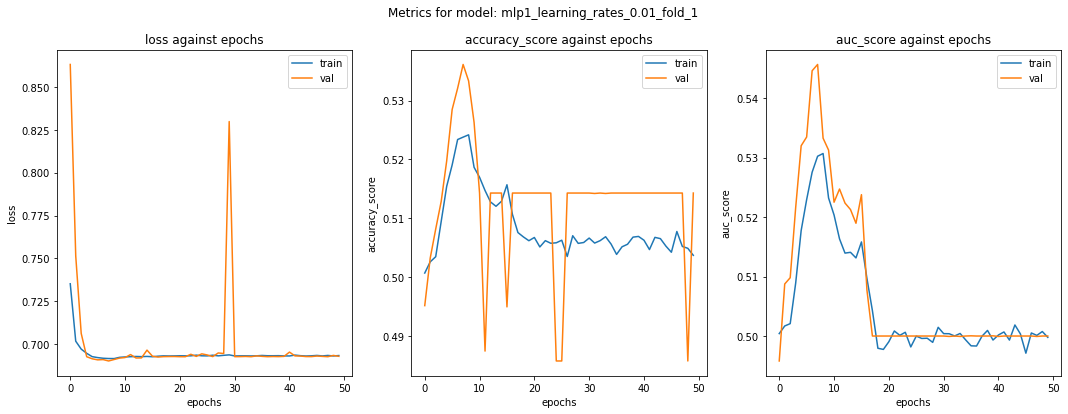

training model fold 2
Epoch 1/50
492/492 [==============================] - 9s 14ms/step - loss: 0.9461 - accuracy: 0.5043 - auc: 0.5058 - val_loss: 0.6932 - val_accuracy: 0.5088 - val_auc: 0.5132
Epoch 2/50
492/492 [==============================] - 7s 13ms/step - loss: 0.7001 - accuracy: 0.5095 - auc: 0.5113 - val_loss: 0.7001 - val_accuracy: 0.5209 - val_auc: 0.5328
Epoch 3/50
492/492 [==============================] - 7s 13ms/step - loss: 0.6969 - accuracy: 0.5100 - auc: 0.5136 - val_loss: 0.6908 - val_accuracy: 0.5283 - val_auc: 0.5389
Epoch 4/50
492/492 [==============================] - 7s 13ms/step - loss: 0.6951 - accuracy: 0.5161 - auc: 0.5196 - val_loss: 0.6902 - val_accuracy: 0.5272 - val_auc: 0.5427
Epoch 5/50
492/492 [==============================] - 7s 13ms/step - loss: 0.6922 - accuracy: 0.5196 - auc: 0.5278 - val_loss: 0.6913 - val_accuracy: 0.5275 - val_auc: 0.5414
Epoch 6/50
492/492 [==============================] - 6s 13ms/step - loss: 0.6925 - accuracy: 0.5221 - 

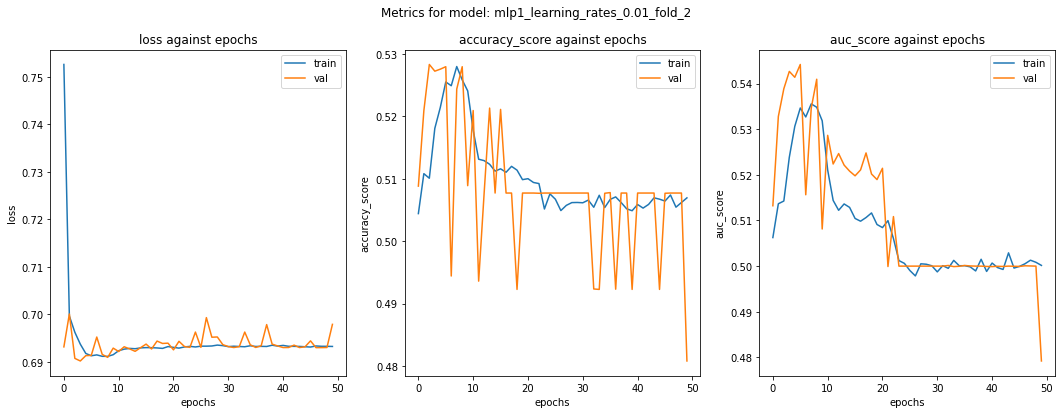

training model fold 3
Epoch 1/50
492/492 [==============================] - 9s 15ms/step - loss: 0.9043 - accuracy: 0.5017 - auc: 0.5016 - val_loss: 0.7675 - val_accuracy: 0.4997 - val_auc: 0.5024
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7031 - accuracy: 0.5034 - auc: 0.5026 - val_loss: 0.6980 - val_accuracy: 0.5124 - val_auc: 0.5022
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6968 - accuracy: 0.5103 - auc: 0.5102 - val_loss: 0.7492 - val_accuracy: 0.5092 - val_auc: 0.5035
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7016 - accuracy: 0.5104 - auc: 0.5125 - val_loss: 0.6921 - val_accuracy: 0.5220 - val_auc: 0.5300
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6926 - accuracy: 0.5195 - auc: 0.5255 - val_loss: 0.6939 - val_accuracy: 0.5142 - val_auc: 0.5225
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6921 - accuracy: 0.5201 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


History saved
History loaded


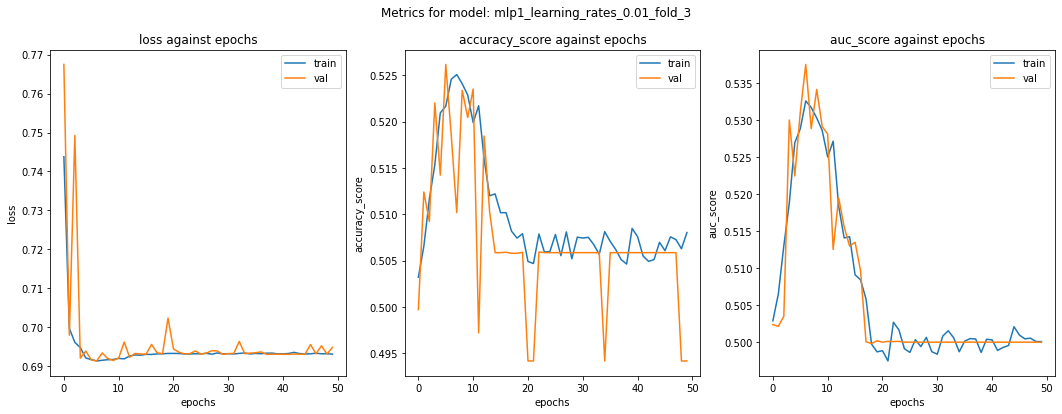

training model fold 4
Epoch 1/50
492/492 [==============================] - 9s 15ms/step - loss: 1.0706 - accuracy: 0.5014 - auc: 0.5006 - val_loss: 0.7157 - val_accuracy: 0.5064 - val_auc: 0.5035
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7012 - accuracy: 0.5020 - auc: 0.5004 - val_loss: 0.7147 - val_accuracy: 0.4918 - val_auc: 0.4912
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7034 - accuracy: 0.5034 - auc: 0.5043 - val_loss: 0.6975 - val_accuracy: 0.4972 - val_auc: 0.5065
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6965 - accuracy: 0.5060 - auc: 0.5066 - val_loss: 0.7259 - val_accuracy: 0.4925 - val_auc: 0.5061
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6963 - accuracy: 0.5142 - auc: 0.5166 - val_loss: 0.6990 - val_accuracy: 0.5136 - val_auc: 0.5214
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6936 - accuracy: 0.5182 - 

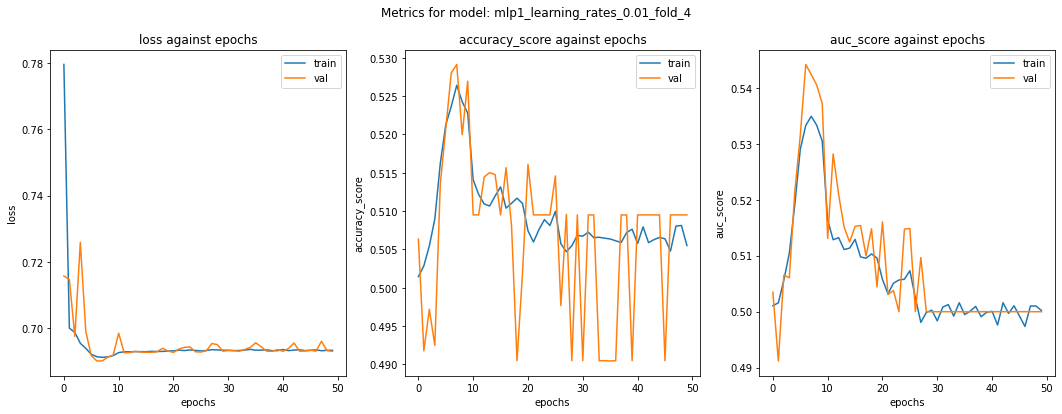

training model fold 5
Epoch 1/50
492/492 [==============================] - 10s 15ms/step - loss: 0.9583 - accuracy: 0.5013 - auc: 0.5012 - val_loss: 0.7043 - val_accuracy: 0.4966 - val_auc: 0.5051
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7006 - accuracy: 0.5036 - auc: 0.5040 - val_loss: 0.6953 - val_accuracy: 0.5147 - val_auc: 0.5181
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6969 - accuracy: 0.5074 - auc: 0.5089 - val_loss: 0.7052 - val_accuracy: 0.4977 - val_auc: 0.5101
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6986 - accuracy: 0.5116 - auc: 0.5151 - val_loss: 0.6921 - val_accuracy: 0.5161 - val_auc: 0.5295
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6934 - accuracy: 0.5172 - auc: 0.5233 - val_loss: 0.6924 - val_accuracy: 0.5207 - val_auc: 0.5357
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6916 - accuracy: 0.5256 -

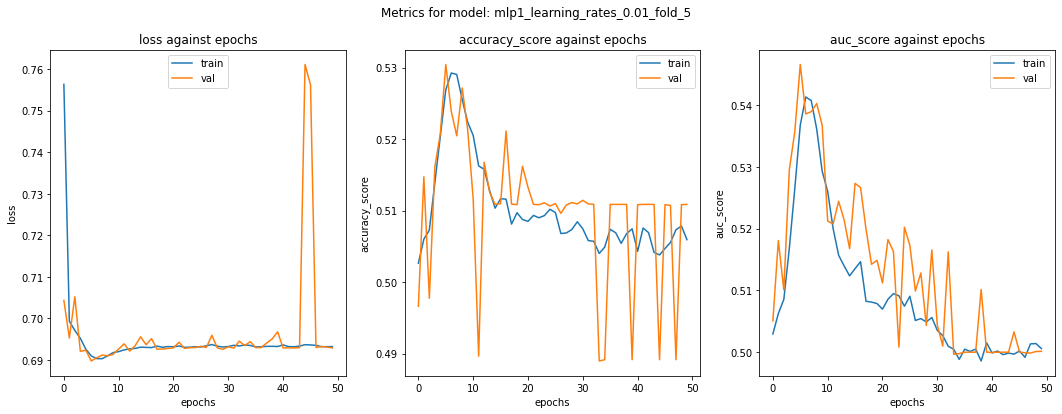

training model fold 6
Epoch 1/50
492/492 [==============================] - 9s 15ms/step - loss: 1.0196 - accuracy: 0.5027 - auc: 0.5025 - val_loss: 0.7020 - val_accuracy: 0.5125 - val_auc: 0.5132
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6998 - accuracy: 0.5048 - auc: 0.5040 - val_loss: 0.7114 - val_accuracy: 0.4902 - val_auc: 0.4959
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7010 - accuracy: 0.5064 - auc: 0.5061 - val_loss: 0.7103 - val_accuracy: 0.4876 - val_auc: 0.4929
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6990 - accuracy: 0.5117 - auc: 0.5138 - val_loss: 0.6932 - val_accuracy: 0.5071 - val_auc: 0.5149
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6938 - accuracy: 0.5144 - auc: 0.5199 - val_loss: 0.6912 - val_accuracy: 0.5262 - val_auc: 0.5333
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6921 - accuracy: 0.5221 - 

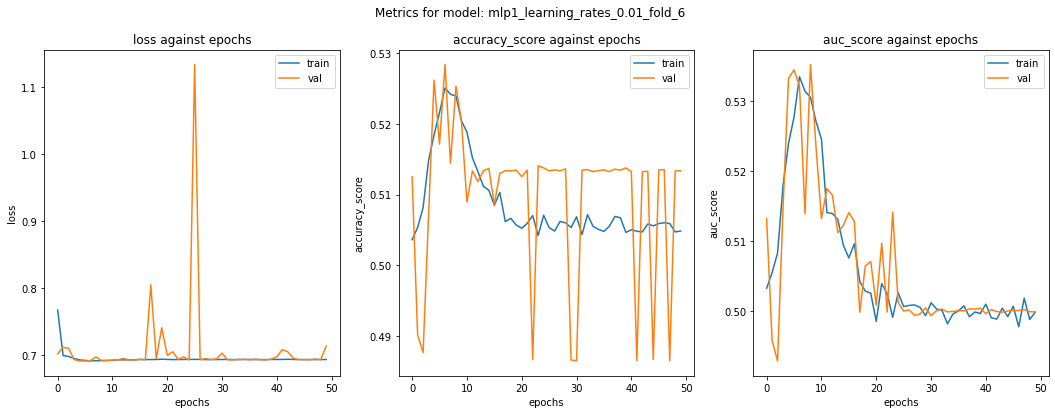

training model fold 7
Epoch 1/50
492/492 [==============================] - 10s 15ms/step - loss: 0.9206 - accuracy: 0.5026 - auc: 0.5024 - val_loss: 0.7058 - val_accuracy: 0.5129 - val_auc: 0.5177
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7004 - accuracy: 0.5061 - auc: 0.5048 - val_loss: 0.7184 - val_accuracy: 0.5093 - val_auc: 0.5107
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7007 - accuracy: 0.5091 - auc: 0.5076 - val_loss: 0.7122 - val_accuracy: 0.4900 - val_auc: 0.4959
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6976 - accuracy: 0.5081 - auc: 0.5085 - val_loss: 0.6986 - val_accuracy: 0.4926 - val_auc: 0.5015
Epoch 5/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6938 - accuracy: 0.5149 - auc: 0.5186 - val_loss: 0.6915 - val_accuracy: 0.5248 - val_auc: 0.5308
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6922 - accuracy: 0.5187 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


History saved
History loaded


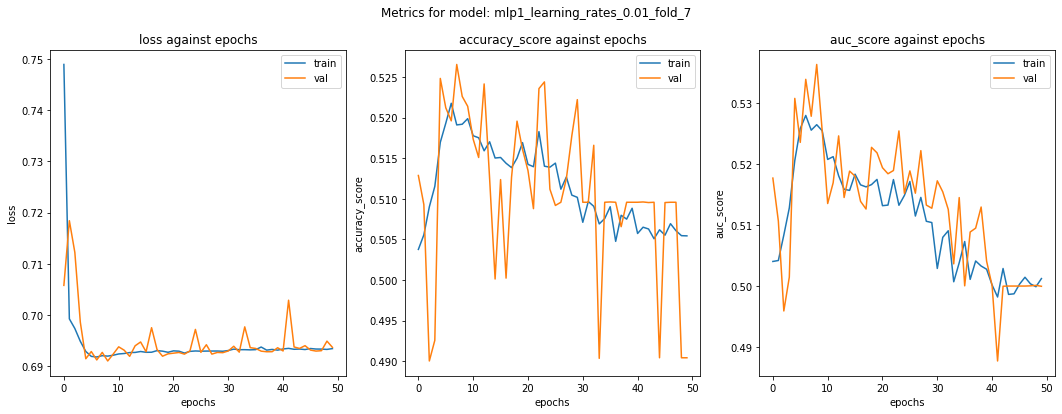

training model fold 8
Epoch 1/50
492/492 [==============================] - 10s 15ms/step - loss: 0.9282 - accuracy: 0.5031 - auc: 0.5026 - val_loss: 0.7635 - val_accuracy: 0.5048 - val_auc: 0.5033
Epoch 2/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7051 - accuracy: 0.5045 - auc: 0.5041 - val_loss: 0.8533 - val_accuracy: 0.5027 - val_auc: 0.5040
Epoch 3/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7090 - accuracy: 0.5070 - auc: 0.5066 - val_loss: 0.7417 - val_accuracy: 0.5003 - val_auc: 0.5099
Epoch 4/50
492/492 [==============================] - 7s 14ms/step - loss: 0.7007 - accuracy: 0.5128 - auc: 0.5154 - val_loss: 0.6964 - val_accuracy: 0.5127 - val_auc: 0.5168
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6940 - accuracy: 0.5176 - auc: 0.5244 - val_loss: 0.6923 - val_accuracy: 0.5163 - val_auc: 0.5216
Epoch 6/50
492/492 [==============================] - 7s 14ms/step - loss: 0.6925 - accuracy: 0.5176 -

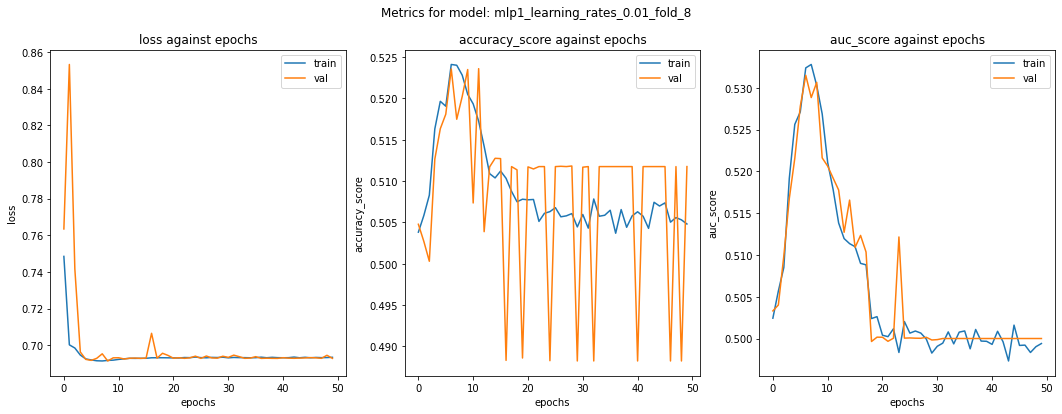

training model fold 9
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8444 - accuracy: 0.5030 - auc: 0.5021 - val_loss: 0.7306 - val_accuracy: 0.4958 - val_auc: 0.4970
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7024 - accuracy: 0.5052 - auc: 0.5043 - val_loss: 0.6942 - val_accuracy: 0.5095 - val_auc: 0.5078
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6975 - accuracy: 0.5061 - auc: 0.5044 - val_loss: 0.6942 - val_accuracy: 0.5137 - val_auc: 0.5171
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6949 - accuracy: 0.5063 - auc: 0.5081 - val_loss: 0.6960 - val_accuracy: 0.4959 - val_auc: 0.5047
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6951 - accuracy: 0.5162 - auc: 0.5140 - val_loss: 0.6923 - val_accuracy: 0.5192 - val_auc: 0.5202
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6923 - accuracy: 0.5223 -

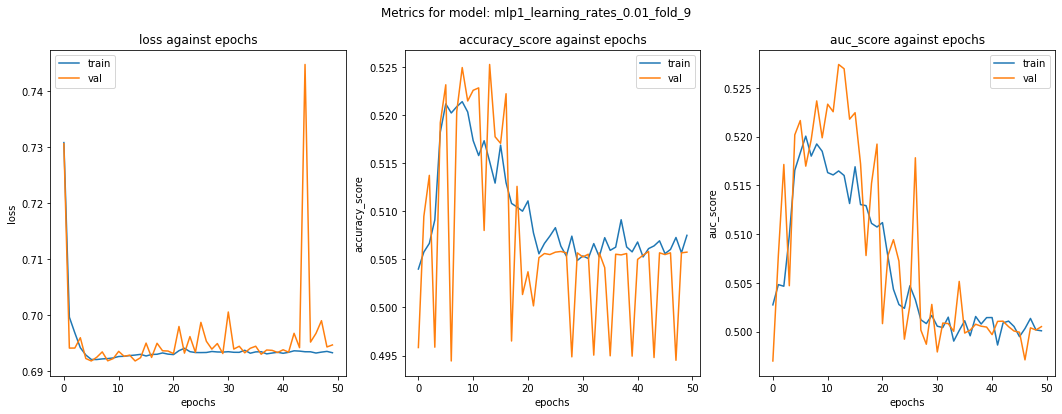

training model fold 10
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 1.0253 - accuracy: 0.5041 - auc: 0.5045 - val_loss: 0.6978 - val_accuracy: 0.4999 - val_auc: 0.5034
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7011 - accuracy: 0.5053 - auc: 0.5044 - val_loss: 0.7134 - val_accuracy: 0.4938 - val_auc: 0.4981
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6994 - accuracy: 0.5054 - auc: 0.5040 - val_loss: 0.7058 - val_accuracy: 0.5077 - val_auc: 0.5184
Epoch 4/50
492/492 [==============================] - 8s 15ms/step - loss: 0.6985 - accuracy: 0.5054 - auc: 0.5050 - val_loss: 0.6949 - val_accuracy: 0.5040 - val_auc: 0.5066
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6947 - accuracy: 0.5072 - auc: 0.5087 - val_loss: 0.6920 - val_accuracy: 0.5224 - val_auc: 0.5187
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.6938 - accuracy: 0.5119 

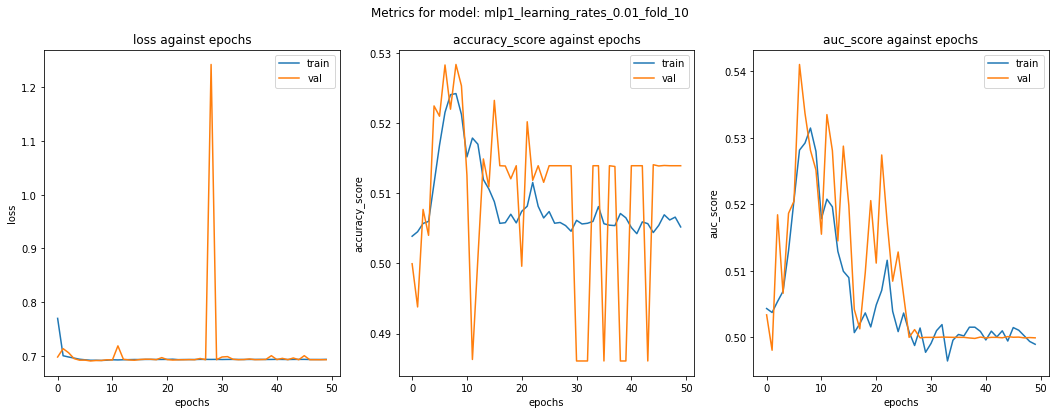

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [nan, 0.5044874725820045, 0.4980840862056578, 10689.0, 3402.9, 10277.3, 3563.9]
saved model metrics

model_name:  mlp1_learning_rates_0.0001
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7f55833c68c0>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8053 - accuracy: 0.5024 - auc: 0.5034 - val_loss: 0.7035 - val_accuracy: 0.5219 - val_auc: 0.5305
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7507 - accuracy: 0.5095 - auc: 0.5123 - val_loss: 0.6996 - val_accuracy: 0.5280 - val_auc: 0.5376
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7348 - accuracy: 0.5124 - auc: 0.5164 - val_loss: 0.6939 - val_accuracy: 0.5396 - val_auc: 0.5538
Epoch 4/50
492/492 [===

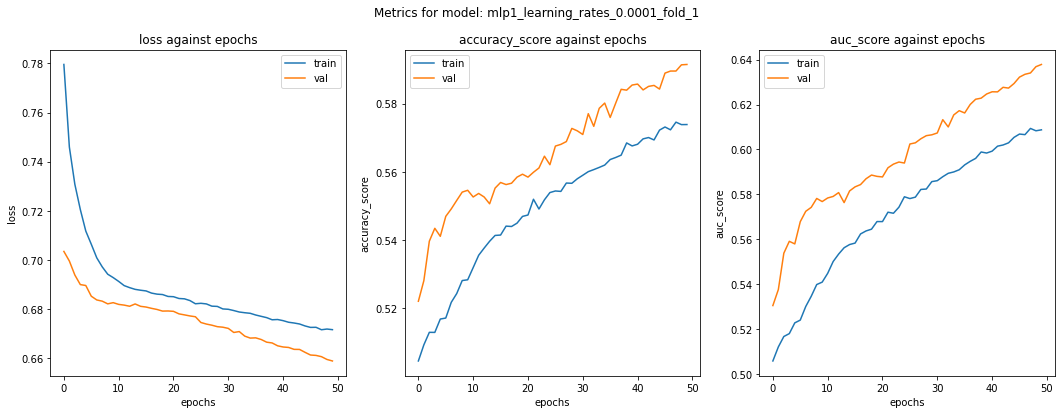

training model fold 2
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8136 - accuracy: 0.5030 - auc: 0.5040 - val_loss: 0.7021 - val_accuracy: 0.5193 - val_auc: 0.5304
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7520 - accuracy: 0.5101 - auc: 0.5134 - val_loss: 0.6976 - val_accuracy: 0.5351 - val_auc: 0.5502
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7373 - accuracy: 0.5110 - auc: 0.5138 - val_loss: 0.6911 - val_accuracy: 0.5376 - val_auc: 0.5553
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7247 - accuracy: 0.5121 - auc: 0.5161 - val_loss: 0.6887 - val_accuracy: 0.5396 - val_auc: 0.5589
Epoch 5/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7138 - accuracy: 0.5168 - auc: 0.5227 - val_loss: 0.6869 - val_accuracy: 0.5435 - val_auc: 0.5641
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7078 - accuracy: 0.5167 -

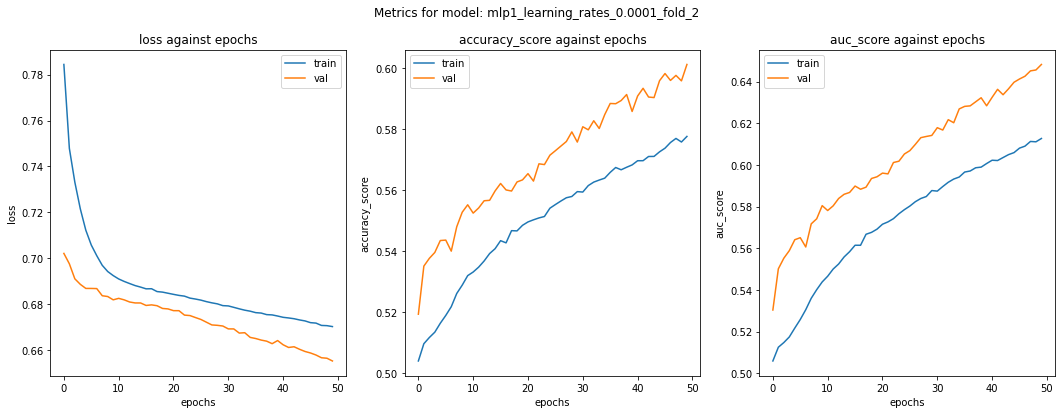

training model fold 3
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8073 - accuracy: 0.5040 - auc: 0.5051 - val_loss: 0.7013 - val_accuracy: 0.5253 - val_auc: 0.5365
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7522 - accuracy: 0.5060 - auc: 0.5088 - val_loss: 0.6965 - val_accuracy: 0.5347 - val_auc: 0.5506
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7347 - accuracy: 0.5108 - auc: 0.5139 - val_loss: 0.6957 - val_accuracy: 0.5349 - val_auc: 0.5515
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7209 - accuracy: 0.5145 - auc: 0.5213 - val_loss: 0.6909 - val_accuracy: 0.5379 - val_auc: 0.5545
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7131 - accuracy: 0.5166 - auc: 0.5226 - val_loss: 0.6898 - val_accuracy: 0.5368 - val_auc: 0.5546
Epoch 6/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7062 - accuracy: 0.5199 -

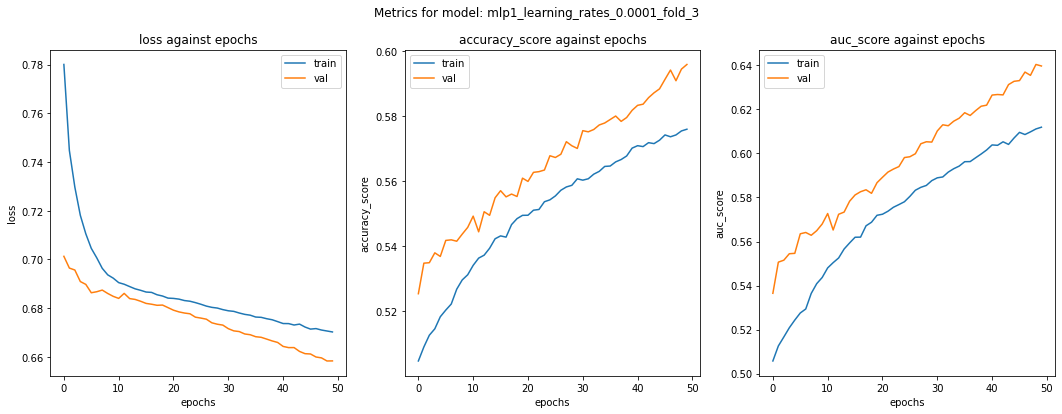

training model fold 4
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8090 - accuracy: 0.5046 - auc: 0.5067 - val_loss: 0.7044 - val_accuracy: 0.5292 - val_auc: 0.5408
Epoch 2/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7539 - accuracy: 0.5084 - auc: 0.5106 - val_loss: 0.6925 - val_accuracy: 0.5356 - val_auc: 0.5538
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7359 - accuracy: 0.5113 - auc: 0.5140 - val_loss: 0.6907 - val_accuracy: 0.5409 - val_auc: 0.5600
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7235 - accuracy: 0.5122 - auc: 0.5174 - val_loss: 0.6900 - val_accuracy: 0.5388 - val_auc: 0.5563
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7160 - accuracy: 0.5152 - auc: 0.5190 - val_loss: 0.6908 - val_accuracy: 0.5406 - val_auc: 0.5587
Epoch 6/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7072 - accuracy: 0.5183 -

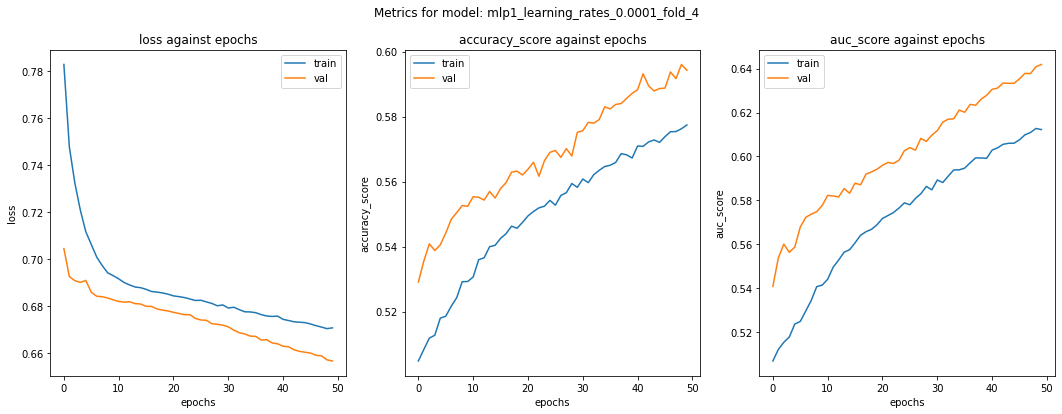

training model fold 5
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8115 - accuracy: 0.5017 - auc: 0.5025 - val_loss: 0.7050 - val_accuracy: 0.5259 - val_auc: 0.5361
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7562 - accuracy: 0.5098 - auc: 0.5117 - val_loss: 0.6977 - val_accuracy: 0.5325 - val_auc: 0.5437
Epoch 3/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7381 - accuracy: 0.5100 - auc: 0.5139 - val_loss: 0.6927 - val_accuracy: 0.5324 - val_auc: 0.5486
Epoch 4/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7245 - accuracy: 0.5142 - auc: 0.5193 - val_loss: 0.6969 - val_accuracy: 0.5350 - val_auc: 0.5470
Epoch 5/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7156 - accuracy: 0.5162 - auc: 0.5225 - val_loss: 0.6889 - val_accuracy: 0.5409 - val_auc: 0.5574
Epoch 6/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7081 - accuracy: 0.5184 -

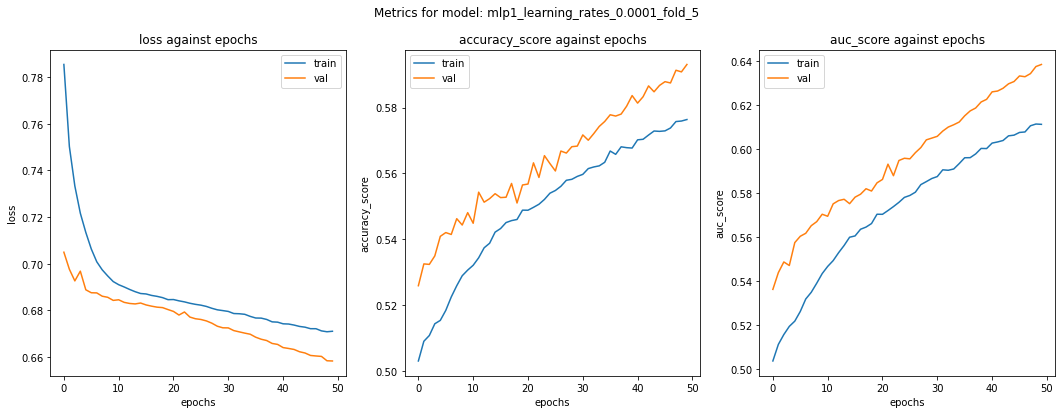

training model fold 6
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8017 - accuracy: 0.5034 - auc: 0.5062 - val_loss: 0.7054 - val_accuracy: 0.5285 - val_auc: 0.5356
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7492 - accuracy: 0.5075 - auc: 0.5111 - val_loss: 0.6980 - val_accuracy: 0.5313 - val_auc: 0.5405
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7320 - accuracy: 0.5112 - auc: 0.5171 - val_loss: 0.6960 - val_accuracy: 0.5351 - val_auc: 0.5516
Epoch 4/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7213 - accuracy: 0.5146 - auc: 0.5198 - val_loss: 0.6888 - val_accuracy: 0.5407 - val_auc: 0.5595
Epoch 5/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7116 - accuracy: 0.5169 - auc: 0.5248 - val_loss: 0.6892 - val_accuracy: 0.5391 - val_auc: 0.5555
Epoch 6/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7062 - accuracy: 0.5193 -

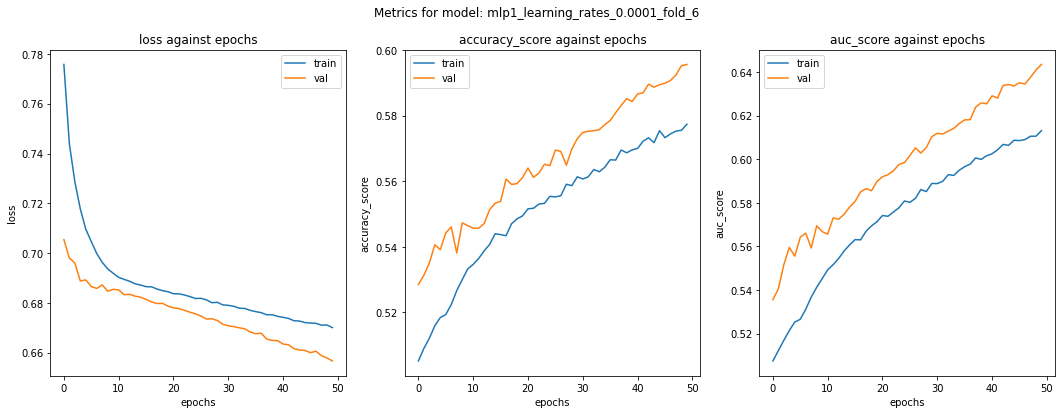

training model fold 7
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8023 - accuracy: 0.5040 - auc: 0.5040 - val_loss: 0.7046 - val_accuracy: 0.5314 - val_auc: 0.5408
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7491 - accuracy: 0.5109 - auc: 0.5145 - val_loss: 0.6964 - val_accuracy: 0.5282 - val_auc: 0.5419
Epoch 3/50
492/492 [==============================] - 7s 15ms/step - loss: 0.7321 - accuracy: 0.5124 - auc: 0.5173 - val_loss: 0.6947 - val_accuracy: 0.5309 - val_auc: 0.5443
Epoch 4/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7231 - accuracy: 0.5124 - auc: 0.5164 - val_loss: 0.6912 - val_accuracy: 0.5349 - val_auc: 0.5510
Epoch 5/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7119 - accuracy: 0.5167 - auc: 0.5244 - val_loss: 0.6893 - val_accuracy: 0.5376 - val_auc: 0.5554
Epoch 6/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7059 - accuracy: 0.5187 -

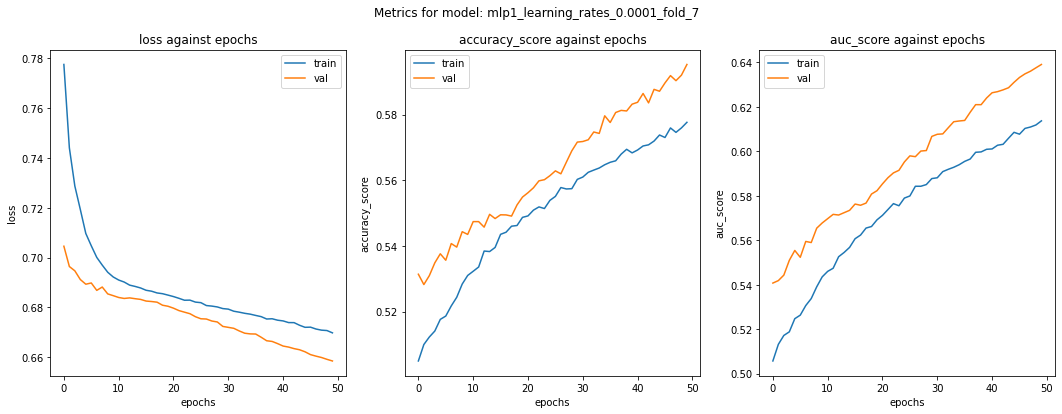

training model fold 8
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8045 - accuracy: 0.5046 - auc: 0.5055 - val_loss: 0.6998 - val_accuracy: 0.5284 - val_auc: 0.5397
Epoch 2/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7503 - accuracy: 0.5092 - auc: 0.5124 - val_loss: 0.6975 - val_accuracy: 0.5282 - val_auc: 0.5398
Epoch 3/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7349 - accuracy: 0.5109 - auc: 0.5149 - val_loss: 0.6922 - val_accuracy: 0.5336 - val_auc: 0.5510
Epoch 4/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7215 - accuracy: 0.5151 - auc: 0.5207 - val_loss: 0.6904 - val_accuracy: 0.5392 - val_auc: 0.5567
Epoch 5/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7122 - accuracy: 0.5179 - auc: 0.5256 - val_loss: 0.6889 - val_accuracy: 0.5365 - val_auc: 0.5571
Epoch 6/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7062 - accuracy: 0.5215 -

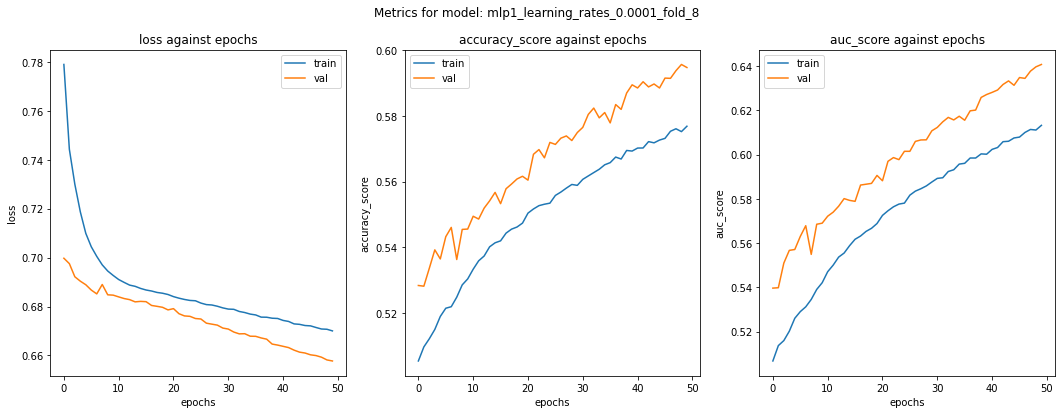

training model fold 9
Epoch 1/50
492/492 [==============================] - 10s 16ms/step - loss: 0.8055 - accuracy: 0.5046 - auc: 0.5040 - val_loss: 0.6984 - val_accuracy: 0.5251 - val_auc: 0.5379
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7536 - accuracy: 0.5086 - auc: 0.5104 - val_loss: 0.6956 - val_accuracy: 0.5314 - val_auc: 0.5465
Epoch 3/50
492/492 [==============================] - 8s 15ms/step - loss: 0.7358 - accuracy: 0.5091 - auc: 0.5134 - val_loss: 0.6918 - val_accuracy: 0.5364 - val_auc: 0.5524
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7242 - accuracy: 0.5132 - auc: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.5361 - val_auc: 0.5530
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7138 - accuracy: 0.5161 - auc: 0.5213 - val_loss: 0.6882 - val_accuracy: 0.5418 - val_auc: 0.5619
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7069 - accuracy: 0.5206 -

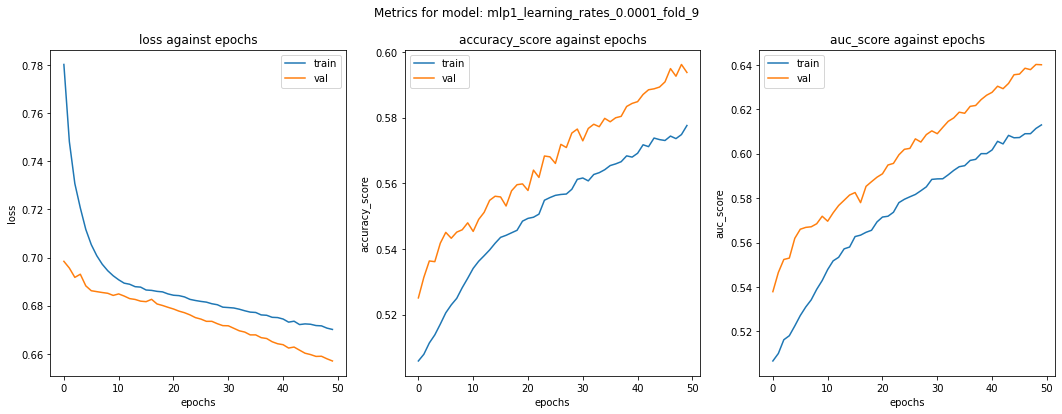

training model fold 10
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.7977 - accuracy: 0.5042 - auc: 0.5044 - val_loss: 0.7023 - val_accuracy: 0.5222 - val_auc: 0.5332
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7461 - accuracy: 0.5080 - auc: 0.5103 - val_loss: 0.6954 - val_accuracy: 0.5310 - val_auc: 0.5444
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7315 - accuracy: 0.5082 - auc: 0.5113 - val_loss: 0.6913 - val_accuracy: 0.5355 - val_auc: 0.5520
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7194 - accuracy: 0.5122 - auc: 0.5174 - val_loss: 0.6897 - val_accuracy: 0.5363 - val_auc: 0.5547
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7107 - accuracy: 0.5178 - auc: 0.5238 - val_loss: 0.6877 - val_accuracy: 0.5394 - val_auc: 0.5580
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.7039 - accuracy: 0.5203 

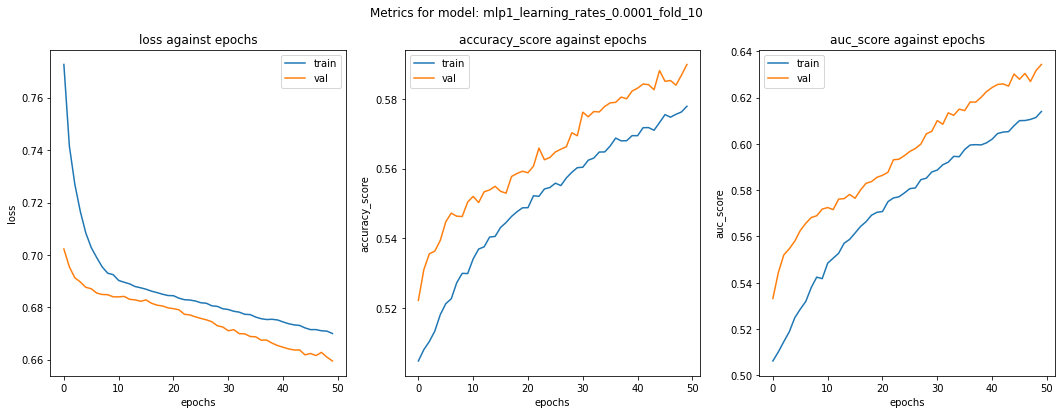

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1023.5876293327547, 0.5945383899430967, 0.5938422633671131, 8931.7, 7675.6, 6004.6, 5321.2]
saved model metrics

model_name:  mlp1_learning_rates_1e-06
model_params:  batch_size=512, hidden_unit=[200, 400, 800, 400], activation=<function tanh at 0x7f55833c68c0>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=1e-06, epoch=50
training model fold 1
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.8866 - accuracy: 0.5010 - auc: 0.5009 - val_loss: 0.7283 - val_accuracy: 0.5028 - val_auc: 0.5054
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8466 - accuracy: 0.5030 - auc: 0.5024 - val_loss: 0.7142 - val_accuracy: 0.5114 - val_auc: 0.5155
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8275 - accuracy: 0.5037 - auc: 0.5048 - val_loss: 0.7091 - val_accuracy: 0.5156 - val_auc: 0.5199
Epoch 4/50
4

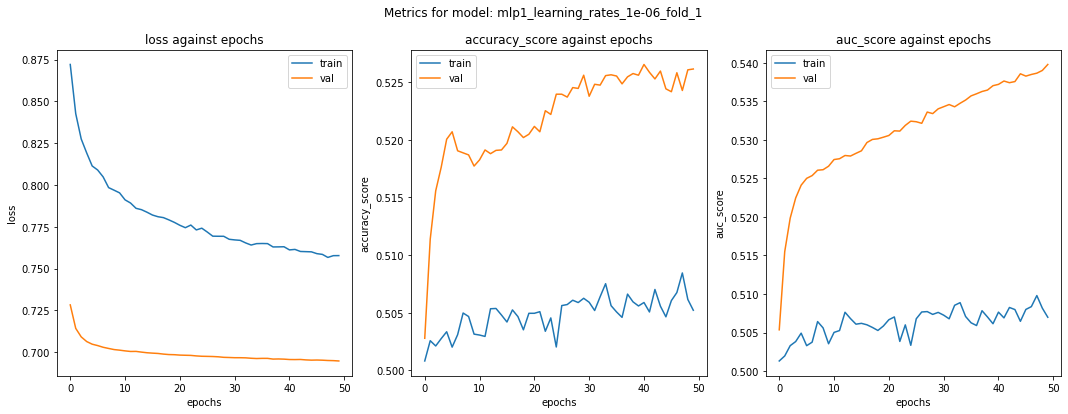

training model fold 2
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.9057 - accuracy: 0.5009 - auc: 0.5015 - val_loss: 0.7314 - val_accuracy: 0.5092 - val_auc: 0.5125
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8600 - accuracy: 0.5021 - auc: 0.5019 - val_loss: 0.7195 - val_accuracy: 0.5093 - val_auc: 0.5130
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8419 - accuracy: 0.5017 - auc: 0.5019 - val_loss: 0.7143 - val_accuracy: 0.5106 - val_auc: 0.5146
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8283 - accuracy: 0.5031 - auc: 0.5050 - val_loss: 0.7118 - val_accuracy: 0.5100 - val_auc: 0.5149
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8202 - accuracy: 0.5016 - auc: 0.5051 - val_loss: 0.7098 - val_accuracy: 0.5105 - val_auc: 0.5148
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8183 - accuracy: 0.5020 -

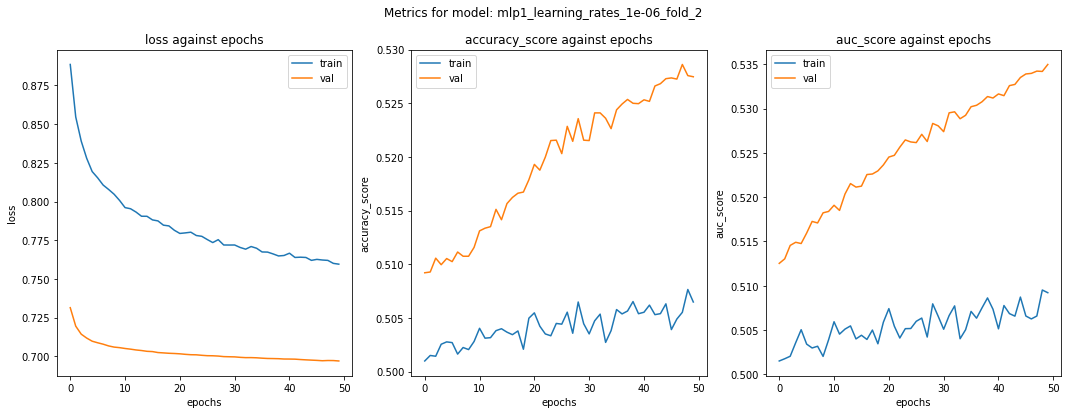

training model fold 3
Epoch 1/50
492/492 [==============================] - 11s 17ms/step - loss: 0.9177 - accuracy: 0.4978 - auc: 0.4974 - val_loss: 0.7387 - val_accuracy: 0.4956 - val_auc: 0.4959
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8720 - accuracy: 0.5009 - auc: 0.5007 - val_loss: 0.7246 - val_accuracy: 0.5010 - val_auc: 0.5034
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8544 - accuracy: 0.5005 - auc: 0.5004 - val_loss: 0.7191 - val_accuracy: 0.5073 - val_auc: 0.5082
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8417 - accuracy: 0.5014 - auc: 0.5019 - val_loss: 0.7154 - val_accuracy: 0.5081 - val_auc: 0.5111
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8326 - accuracy: 0.5050 - auc: 0.5048 - val_loss: 0.7129 - val_accuracy: 0.5119 - val_auc: 0.5129
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8270 - accuracy: 0.5035 -

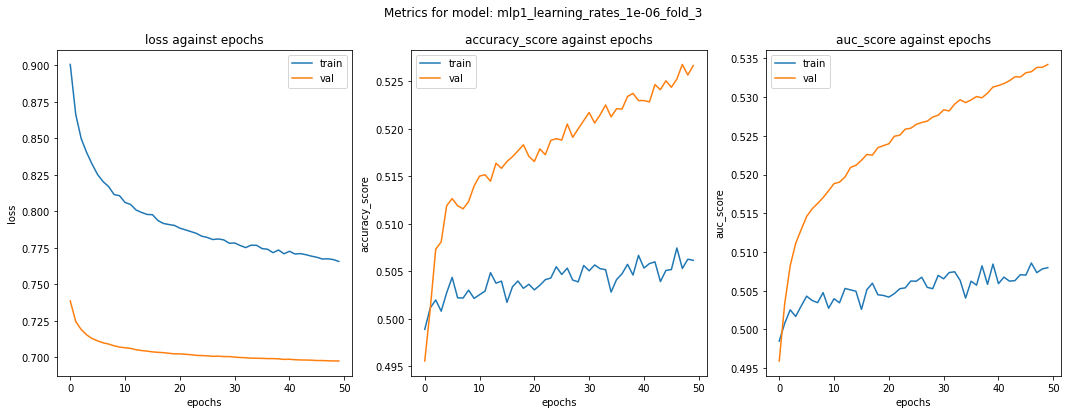

training model fold 4
Epoch 1/50
492/492 [==============================] - 10s 17ms/step - loss: 0.9080 - accuracy: 0.4970 - auc: 0.4976 - val_loss: 0.7352 - val_accuracy: 0.5040 - val_auc: 0.5066
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8555 - accuracy: 0.5022 - auc: 0.5037 - val_loss: 0.7233 - val_accuracy: 0.5082 - val_auc: 0.5119
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8412 - accuracy: 0.5023 - auc: 0.5028 - val_loss: 0.7179 - val_accuracy: 0.5093 - val_auc: 0.5144
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8293 - accuracy: 0.5025 - auc: 0.5046 - val_loss: 0.7143 - val_accuracy: 0.5106 - val_auc: 0.5163
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8211 - accuracy: 0.5030 - auc: 0.5050 - val_loss: 0.7123 - val_accuracy: 0.5141 - val_auc: 0.5187
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8181 - accuracy: 0.5020 -

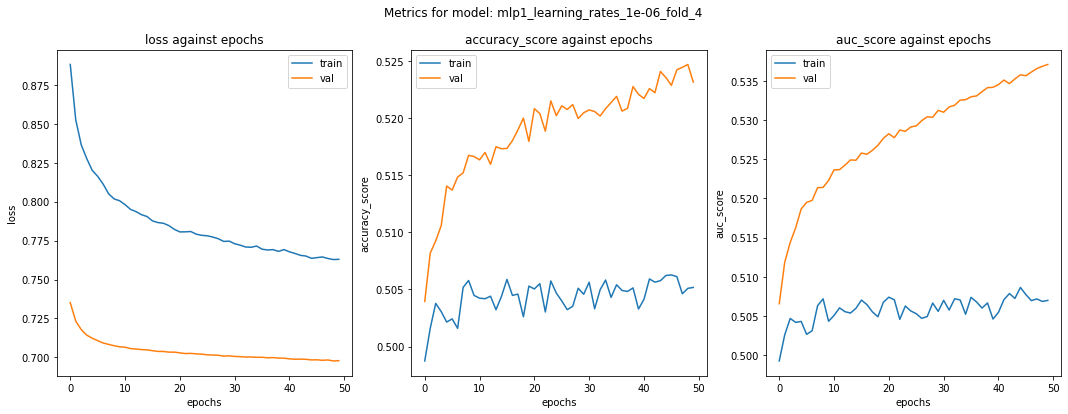

training model fold 5
Epoch 1/50
492/492 [==============================] - 11s 18ms/step - loss: 0.8906 - accuracy: 0.5046 - auc: 0.5065 - val_loss: 0.7311 - val_accuracy: 0.5101 - val_auc: 0.5125
Epoch 2/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8539 - accuracy: 0.5012 - auc: 0.5012 - val_loss: 0.7186 - val_accuracy: 0.5101 - val_auc: 0.5128
Epoch 3/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8398 - accuracy: 0.5013 - auc: 0.5020 - val_loss: 0.7142 - val_accuracy: 0.5092 - val_auc: 0.5135
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8313 - accuracy: 0.5015 - auc: 0.5017 - val_loss: 0.7122 - val_accuracy: 0.5096 - val_auc: 0.5145
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8216 - accuracy: 0.5012 - auc: 0.5035 - val_loss: 0.7110 - val_accuracy: 0.5109 - val_auc: 0.5155
Epoch 6/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8150 - accuracy: 0.5046 -

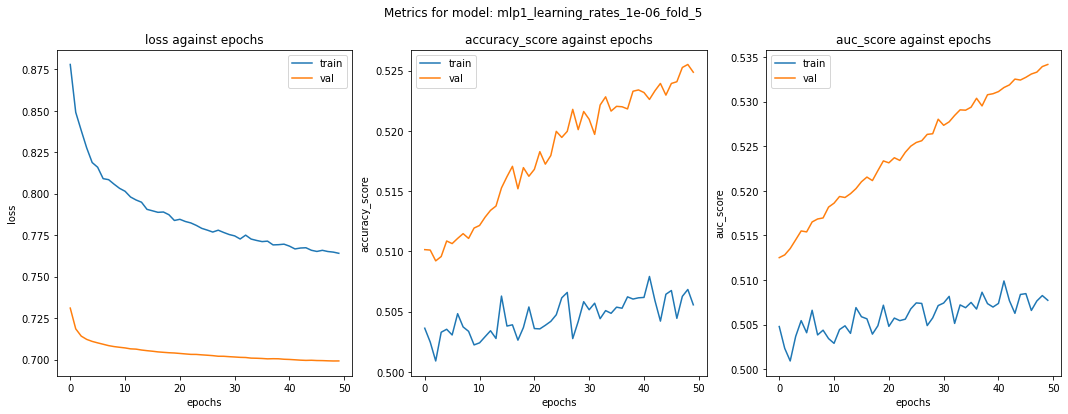

training model fold 6
Epoch 1/50
492/492 [==============================] - 11s 18ms/step - loss: 0.9053 - accuracy: 0.4951 - auc: 0.4957 - val_loss: 0.7325 - val_accuracy: 0.5031 - val_auc: 0.5070
Epoch 2/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8531 - accuracy: 0.5025 - auc: 0.5021 - val_loss: 0.7194 - val_accuracy: 0.5091 - val_auc: 0.5122
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8388 - accuracy: 0.5023 - auc: 0.5017 - val_loss: 0.7136 - val_accuracy: 0.5112 - val_auc: 0.5152
Epoch 4/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8277 - accuracy: 0.5050 - auc: 0.5038 - val_loss: 0.7105 - val_accuracy: 0.5129 - val_auc: 0.5180
Epoch 5/50
492/492 [==============================] - 8s 16ms/step - loss: 0.8210 - accuracy: 0.5045 - auc: 0.5039 - val_loss: 0.7086 - val_accuracy: 0.5139 - val_auc: 0.5189
Epoch 6/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8151 - accuracy: 0.5016 -

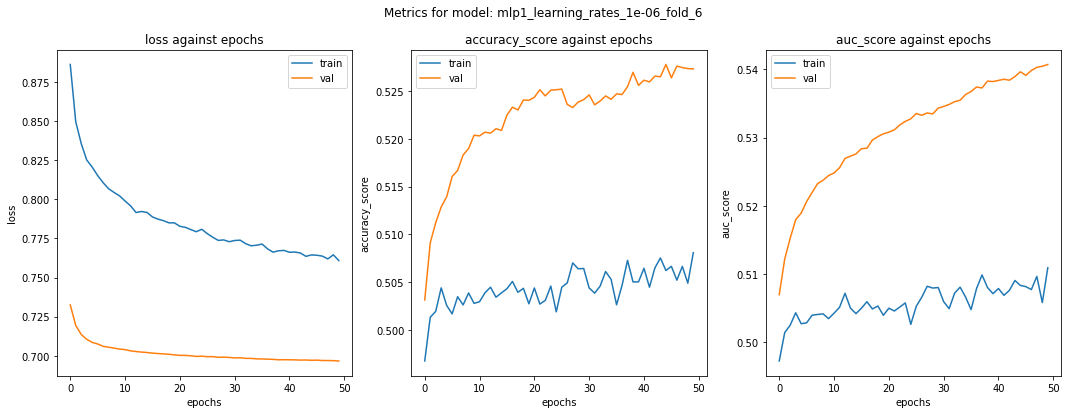

training model fold 7
Epoch 1/50
492/492 [==============================] - 11s 18ms/step - loss: 0.9077 - accuracy: 0.5055 - auc: 0.5061 - val_loss: 0.7341 - val_accuracy: 0.5051 - val_auc: 0.5078
Epoch 2/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8560 - accuracy: 0.5045 - auc: 0.5068 - val_loss: 0.7214 - val_accuracy: 0.5095 - val_auc: 0.5138
Epoch 3/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8421 - accuracy: 0.5043 - auc: 0.5056 - val_loss: 0.7162 - val_accuracy: 0.5105 - val_auc: 0.5155
Epoch 4/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8340 - accuracy: 0.5039 - auc: 0.5039 - val_loss: 0.7142 - val_accuracy: 0.5122 - val_auc: 0.5176
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8256 - accuracy: 0.5031 - auc: 0.5044 - val_loss: 0.7122 - val_accuracy: 0.5120 - val_auc: 0.5174
Epoch 6/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8194 - accuracy: 0.5018 -

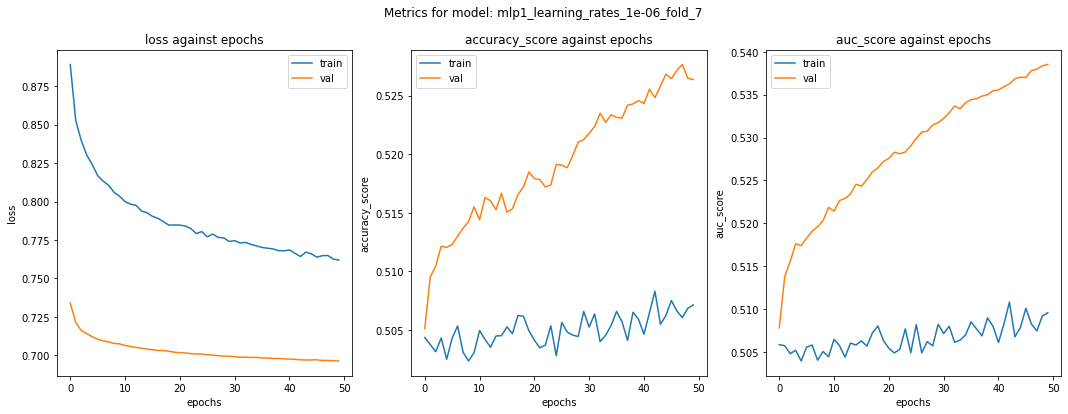

training model fold 8
Epoch 1/50
492/492 [==============================] - 11s 18ms/step - loss: 0.9356 - accuracy: 0.5011 - auc: 0.4998 - val_loss: 0.7379 - val_accuracy: 0.4989 - val_auc: 0.5002
Epoch 2/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8677 - accuracy: 0.5003 - auc: 0.5001 - val_loss: 0.7237 - val_accuracy: 0.5016 - val_auc: 0.5056
Epoch 3/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8480 - accuracy: 0.5035 - auc: 0.5042 - val_loss: 0.7181 - val_accuracy: 0.5069 - val_auc: 0.5082
Epoch 4/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8394 - accuracy: 0.4991 - auc: 0.5004 - val_loss: 0.7153 - val_accuracy: 0.5081 - val_auc: 0.5101
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8329 - accuracy: 0.5011 - auc: 0.5011 - val_loss: 0.7129 - val_accuracy: 0.5075 - val_auc: 0.5117
Epoch 6/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8227 - accuracy: 0.5033 -

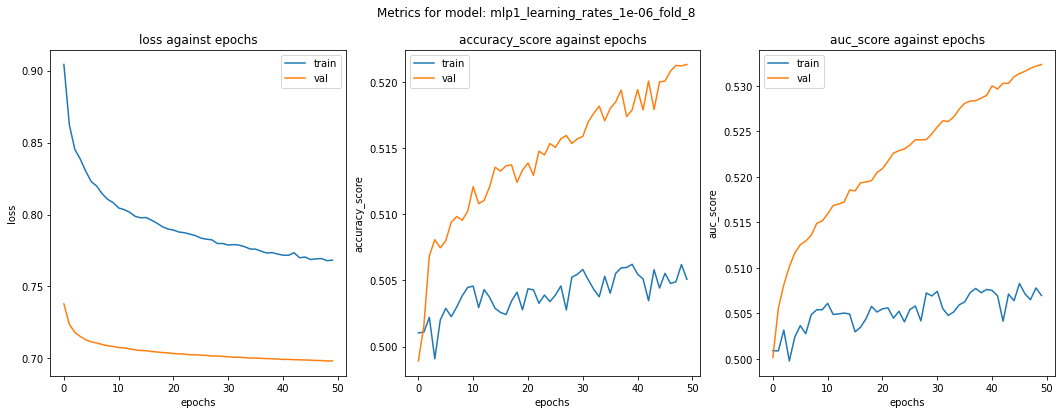

training model fold 9
Epoch 1/50
492/492 [==============================] - 11s 18ms/step - loss: 0.8982 - accuracy: 0.5004 - auc: 0.5004 - val_loss: 0.7361 - val_accuracy: 0.5048 - val_auc: 0.5055
Epoch 2/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8527 - accuracy: 0.5018 - auc: 0.5036 - val_loss: 0.7221 - val_accuracy: 0.5033 - val_auc: 0.5088
Epoch 3/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8357 - accuracy: 0.5025 - auc: 0.5035 - val_loss: 0.7174 - val_accuracy: 0.5069 - val_auc: 0.5109
Epoch 4/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8295 - accuracy: 0.5010 - auc: 0.5020 - val_loss: 0.7145 - val_accuracy: 0.5077 - val_auc: 0.5122
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8216 - accuracy: 0.5017 - auc: 0.5031 - val_loss: 0.7125 - val_accuracy: 0.5099 - val_auc: 0.5128
Epoch 6/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8155 - accuracy: 0.5030 -

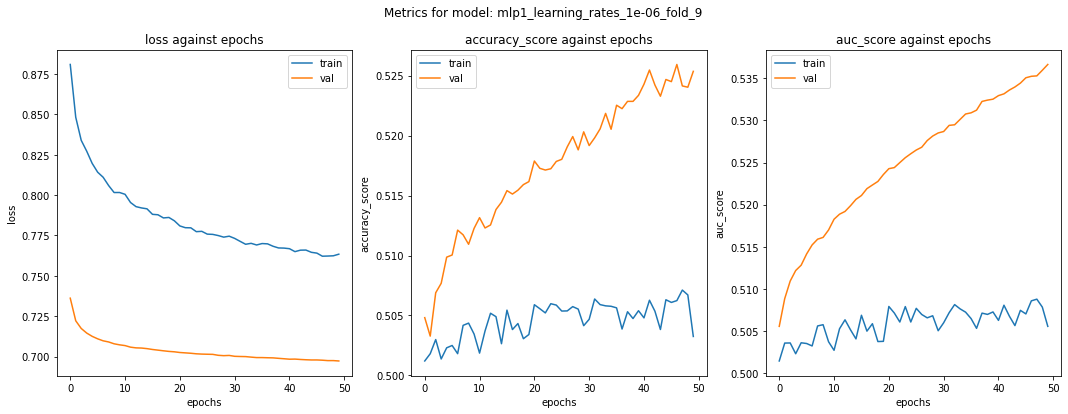

training model fold 10
Epoch 1/50
492/492 [==============================] - 11s 18ms/step - loss: 0.9351 - accuracy: 0.4992 - auc: 0.4978 - val_loss: 0.7373 - val_accuracy: 0.5028 - val_auc: 0.5057
Epoch 2/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8604 - accuracy: 0.5034 - auc: 0.5030 - val_loss: 0.7240 - val_accuracy: 0.5077 - val_auc: 0.5116
Epoch 3/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8454 - accuracy: 0.5019 - auc: 0.5025 - val_loss: 0.7181 - val_accuracy: 0.5111 - val_auc: 0.5144
Epoch 4/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8347 - accuracy: 0.5036 - auc: 0.5033 - val_loss: 0.7153 - val_accuracy: 0.5113 - val_auc: 0.5162
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8250 - accuracy: 0.5046 - auc: 0.5057 - val_loss: 0.7127 - val_accuracy: 0.5110 - val_auc: 0.5163
Epoch 6/50
492/492 [==============================] - 8s 17ms/step - loss: 0.8203 - accuracy: 0.5036 

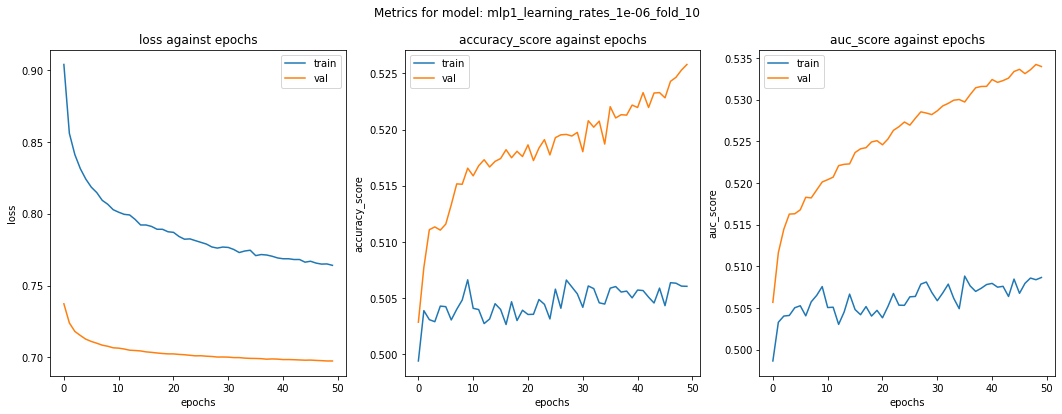

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [94.7770119147178, 0.5254447208211511, 0.5246722407128328, 8002.1, 6675.2, 7005.0, 6250.8]
saved model metrics


In [ ]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "11F_nndl_cv_mlp1_learning_rates"
            model_name = f"mlp1_learning_rates_{learning_rate}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                     
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [ ]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [ ]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion

Best performing hyperparameters : learning_rates = 0.0001
* Utility score: 1023.58762933275
* Accuracy: 0.594538389943096

Too high a learning rate, and too low both give terrible scores

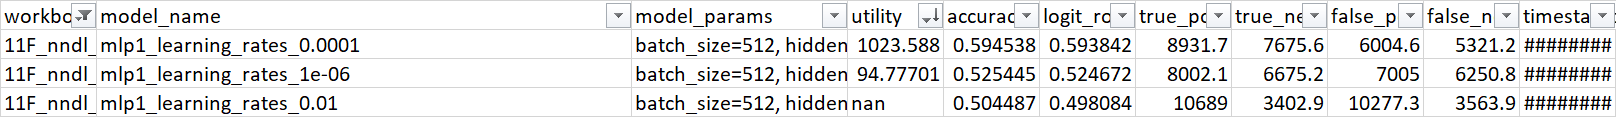